In [ ]:
SAVE_ON_DRIVE = True
TYPE = 'Train'

# Dataset initialization


### Download Data

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/LoveDA/Train'
if (os.path.exists("./Train") == False):
    if (os.path.exists("/content/drive/MyDrive/LoveDA/Train.zip")):
        print("Dataset available on own drive, unzipping...")
        !unzip -q /content/drive/MyDrive/LoveDA/Train.zip -d ./
    else:
        print("Downloading dataset...")
        !wget -O Train.zip "https://zenodo.org/records/5706578/files/Train.zip?download=1"
        if(SAVE_ON_DRIVE):
            print("Saving dataset on drive...")
            !cp Train.zip /content/drive/MyDrive/LoveDA/
        !unzip -q Train.zip -d ./

else:
    print("Dataset already in local")


Mounted at /content/drive
Dataset available on own drive, unzipping...


### Import Boundaries

In [ ]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

# if (rural_file_count != rural_mask_file_count):
#     print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
#     shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
# else:
#     print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

Creating ./Train/Rural/boundaries_png...
Creating ./Train/Urban/boundaries_png...
Importing boundaries, as we have 0 urban boundaries as of now...


### Dataset Definition

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, transforms, split = 'Urban', type = 'Train', useBoundaries=True, validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation', 'Total']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation'.")
        self.directory = []
        directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        elif type == 'Total':
            self.directory = all_images
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total'.")
        self.transforms = transforms
        self.useBoundaries = useBoundaries
        # Print dataset size
        print(f"Dataset size: {len(self.directory)}")

      # Define albumentations transforms

      #   # WITH AUGMENTATIONS
      #   self.transforms = A.Compose([
      #     A.RandomCrop(256, 256),
      #     A.OneOf([
      #         A.HorizontalFlip(p=1),
      #         A.VerticalFlip(p=1),
      #         A.RandomRotate90(p=1)
      #     ], p=0.75),
      #     A.Normalize(mean=(123.675, 116.28, 103.53),
      #                 std=(58.395, 57.12, 57.375),
      #                 max_pixel_value=1.0, always_apply=True),
      #     ToTensorV2()
      # ])


    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')
        boundaries_path = image_path.replace('images_png', 'boundaries_png')

        mask = pil_loader(mask_path, 'L')
        if self.useBoundaries:
          boundaries = pil_loader(boundaries_path, 'L')
          # Apply transformations
          augmented = self.transforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        else:
          augmented = self.transforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(mask))

        image = T.Compose([T.ToTensor()])(augmented['image'])

        mask = augmented['mask']
        mask = torch.from_numpy(mask).long()
        mask = mask-1


        boundaries = augmented['boundaries']
        boundaries = torch.from_numpy(boundaries)


        return image, mask, image_path, boundaries

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Dataset Utils

In [ ]:
import matplotlib.patches as mpatches

from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



# Initialize model

### STDC Net

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import math



class ConvX(nn.Module):
    def __init__(self, in_planes, out_planes, kernel=3, stride=1):
        super(ConvX, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel, stride=stride, padding=kernel//2, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


class AddBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, block_num=3, stride=1):
        super(AddBottleneck, self).__init__()
        assert block_num > 1, print("block number should be larger than 1.")
        self.conv_list = nn.ModuleList()
        self.stride = stride
        if stride == 2:
            self.avd_layer = nn.Sequential(
                nn.Conv2d(out_planes//2, out_planes//2, kernel_size=3, stride=2, padding=1, groups=out_planes//2, bias=False),
                nn.BatchNorm2d(out_planes//2),
            )
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1, groups=in_planes, bias=False),
                nn.BatchNorm2d(in_planes),
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes),
            )
            stride = 1

        for idx in range(block_num):
            if idx == 0:
                self.conv_list.append(ConvX(in_planes, out_planes//2, kernel=1))
            elif idx == 1 and block_num == 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//2, stride=stride))
            elif idx == 1 and block_num > 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//4, stride=stride))
            elif idx < block_num - 1:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx+1))))
            else:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx))))

    def forward(self, x):
        out_list = []
        out = x

        for idx, conv in enumerate(self.conv_list):
            if idx == 0 and self.stride == 2:
                out = self.avd_layer(conv(out))
            else:
                out = conv(out)
            out_list.append(out)

        if self.stride == 2:
            x = self.skip(x)

        return torch.cat(out_list, dim=1) + x



class CatBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, block_num=3, stride=1):
        super(CatBottleneck, self).__init__()
        assert block_num > 1, print("block number should be larger than 1.")
        self.conv_list = nn.ModuleList()
        self.stride = stride
        if stride == 2:
            self.avd_layer = nn.Sequential(
                nn.Conv2d(out_planes//2, out_planes//2, kernel_size=3, stride=2, padding=1, groups=out_planes//2, bias=False),
                nn.BatchNorm2d(out_planes//2),
            )
            self.skip = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            stride = 1

        for idx in range(block_num):
            if idx == 0:
                self.conv_list.append(ConvX(in_planes, out_planes//2, kernel=1))
            elif idx == 1 and block_num == 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//2, stride=stride))
            elif idx == 1 and block_num > 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//4, stride=stride))
            elif idx < block_num - 1:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx+1))))
            else:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx))))

    def forward(self, x):
        out_list = []
        out1 = self.conv_list[0](x)

        for idx, conv in enumerate(self.conv_list[1:]):
            if idx == 0:
                if self.stride == 2:
                    out = conv(self.avd_layer(out1))
                else:
                    out = conv(out1)
            else:
                out = conv(out)
            out_list.append(out)

        if self.stride == 2:
            out1 = self.skip(out1)
        out_list.insert(0, out1)

        out = torch.cat(out_list, dim=1)
        return out

#STDC2Net
class STDCNet1446(nn.Module):
    def __init__(self, base=64, layers=[4,5,3], block_num=4, type="cat", num_classes=1000, dropout=0.20, pretrain_model='', use_conv_last=False):
        super(STDCNet1446, self).__init__()
        if type == "cat":
            block = CatBottleneck
        elif type == "add":
            block = AddBottleneck
        self.use_conv_last = use_conv_last
        self.features = self._make_layers(base, layers, block_num, block)
        self.conv_last = ConvX(base*16, max(1024, base*16), 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(max(1024, base*16), max(1024, base*16), bias=False)
        self.bn = nn.BatchNorm1d(max(1024, base*16))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(max(1024, base*16), num_classes, bias=False)

        self.x2 = nn.Sequential(self.features[:1])
        self.x4 = nn.Sequential(self.features[1:2])
        self.x8 = nn.Sequential(self.features[2:6])
        self.x16 = nn.Sequential(self.features[6:11])
        self.x32 = nn.Sequential(self.features[11:])

        if pretrain_model:
            print('use pretrain model {}'.format(pretrain_model))
            self.init_weight(pretrain_model)
        else:
            self.init_params()

    def init_weight(self, pretrain_model):

        state_dict = torch.load(pretrain_model)["state_dict"]
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def _make_layers(self, base, layers, block_num, block):
        features = []
        features += [ConvX(3, base//2, 3, 2)]
        features += [ConvX(base//2, base, 3, 2)]

        for i, layer in enumerate(layers):
            for j in range(layer):
                if i == 0 and j == 0:
                    features.append(block(base, base*4, block_num, 2))
                elif j == 0:
                    features.append(block(base*int(math.pow(2,i+1)), base*int(math.pow(2,i+2)), block_num, 2))
                else:
                    features.append(block(base*int(math.pow(2,i+2)), base*int(math.pow(2,i+2)), block_num, 1))

        return nn.Sequential(*features)

    def forward(self, x):
        feat2 = self.x2(x)
        feat4 = self.x4(feat2)
        feat8 = self.x8(feat4)
        feat16 = self.x16(feat8)
        feat32 = self.x32(feat16)
        if self.use_conv_last:
           feat32 = self.conv_last(feat32)

        return feat2, feat4, feat8, feat16, feat32

    def forward_impl(self, x):
        out = self.features(x)
        out = self.conv_last(out).pow(2)
        out = self.gap(out).flatten(1)
        out = self.fc(out)
        # out = self.bn(out)
        out = self.relu(out)
        # out = self.relu(self.bn(self.fc(out)))
        out = self.dropout(out)
        out = self.linear(out)
        return out

# STDC1Net
class STDCNet813(nn.Module):
    def __init__(self, base=64, layers=[2,2,2], block_num=4, type="cat", num_classes=1000, dropout=0.20, pretrain_model='', use_conv_last=False):
        super(STDCNet813, self).__init__()
        if type == "cat":
            block = CatBottleneck
        elif type == "add":
            block = AddBottleneck
        self.use_conv_last = use_conv_last
        self.features = self._make_layers(base, layers, block_num, block)
        self.conv_last = ConvX(base*16, max(1024, base*16), 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(max(1024, base*16), max(1024, base*16), bias=False)
        self.bn = nn.BatchNorm1d(max(1024, base*16))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(max(1024, base*16), num_classes, bias=False)

        self.x2 = nn.Sequential(self.features[:1])
        self.x4 = nn.Sequential(self.features[1:2])
        self.x8 = nn.Sequential(self.features[2:4])
        self.x16 = nn.Sequential(self.features[4:6])
        self.x32 = nn.Sequential(self.features[6:])

        if pretrain_model:
            print('use pretrain model {}'.format(pretrain_model))
            self.init_weight(pretrain_model)
        else:
            self.init_params()

    def init_weight(self, pretrain_model):

        state_dict = torch.load(pretrain_model)["state_dict"]
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def _make_layers(self, base, layers, block_num, block):
        features = []
        features += [ConvX(3, base//2, 3, 2)]
        features += [ConvX(base//2, base, 3, 2)]

        for i, layer in enumerate(layers):
            for j in range(layer):
                if i == 0 and j == 0:
                    features.append(block(base, base*4, block_num, 2))
                elif j == 0:
                    features.append(block(base*int(math.pow(2,i+1)), base*int(math.pow(2,i+2)), block_num, 2))
                else:
                    features.append(block(base*int(math.pow(2,i+2)), base*int(math.pow(2,i+2)), block_num, 1))

        return nn.Sequential(*features)

    def forward(self, x):
        feat2 = self.x2(x)
        feat4 = self.x4(feat2)
        feat8 = self.x8(feat4)
        feat16 = self.x16(feat8)
        feat32 = self.x32(feat16)
        if self.use_conv_last:
           feat32 = self.conv_last(feat32)

        return feat2, feat4, feat8, feat16, feat32

    def forward_impl(self, x):
        out = self.features(x)
        out = self.conv_last(out).pow(2)
        out = self.gap(out).flatten(1)
        out = self.fc(out)
        # out = self.bn(out)
        out = self.relu(out)
        # out = self.relu(self.bn(self.fc(out)))
        out = self.dropout(out)
        out = self.linear(out)
        return out

### STDC Definition

In [ ]:
#!/usr/bin/python
# -*- encoding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

BatchNorm2d = nn.BatchNorm2d

class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = BatchNorm2d(out_chan)
        # self.bn = BatchNorm2d(out_chan, activation='none')
        self.relu = nn.ReLU()
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = BatchNorm2d(out_chan)
        # self.bn_atten = BatchNorm2d(out_chan, activation='none')
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        # atten = F.avg_pool2d(feat, feat.size()[2:])
        size_array = [int(s) for s in feat.size()[2:]]
        atten = torch.nn.functional.avg_pool2d(feat, size_array)
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, backbone='CatNetSmall', pretrain_model='', use_conv_last=False, input_size=512, *args, **kwargs):
        super(ContextPath, self).__init__()

        self.backbone_name = backbone
        self.input_size = input_size
        print('backbone: ', backbone)
        if backbone == 'STDCNet1446':
            self.backbone = STDCNet1446(pretrain_model=pretrain_model, use_conv_last=use_conv_last)
            self.arm16 = AttentionRefinementModule(512, 128)
            inplanes = 1024
            if use_conv_last:
                inplanes = 1024
            self.arm32 = AttentionRefinementModule(inplanes, 128)
            self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_avg = ConvBNReLU(inplanes, 128, ks=1, stride=1, padding=0)

        elif backbone == 'STDCNet813':
            self.backbone = STDCNet813(pretrain_model=pretrain_model, use_conv_last=use_conv_last)
            self.arm16 = AttentionRefinementModule(512, 128)
            inplanes = 1024
            if use_conv_last:
                inplanes = 1024
            self.arm32 = AttentionRefinementModule(inplanes, 128)
            self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_avg = ConvBNReLU(inplanes, 128, ks=1, stride=1, padding=0)
        else:
            print("backbone is not in backbone lists")
            exit(0)

        if self.input_size == 512:
            self.H8 = torch.tensor(64)
            self.W8 = torch.tensor(128)

            self.H16 = torch.tensor(32)
            self.W16 = torch.tensor(64)

            self.H32 = torch.tensor(16)
            self.W32 = torch.tensor(32)
        elif self.input_size == 768:
            self.H8 = torch.tensor(96)
            self.W8 = torch.tensor(192)

            self.H16 = torch.tensor(48)
            self.W16 = torch.tensor(96)

            self.H32 = torch.tensor(24)
            self.W32 = torch.tensor(48)
        elif self.input_size == 1024:
            self.H8 = torch.tensor(128)
            self.W8 = torch.tensor(256)

            self.H16 = torch.tensor(64)
            self.W16 = torch.tensor(128)

            self.H32 = torch.tensor(32)
            self.W32 = torch.tensor(64)

        elif self.input_size == 720:
            self.H8 = torch.tensor(90)
            self.W8 = torch.tensor(120)

            self.H16 = torch.tensor(45)
            self.W16 = torch.tensor(60)

            self.H32 = torch.tensor(23)
            self.W32 = torch.tensor(30)
        else:
            print("input_size is not in input_size lists")
            exit(0)

        self.init_weight()

    def forward(self, x):

        feat2, feat4, feat8, feat16, feat32 = self.backbone(x)
        size_array = [int(s) for s in feat32.size()[2:]]
        avg = torch.nn.functional.avg_pool2d(feat32, size_array)

        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (self.H32, self.W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        # Debugging: print the shapes of feat32_arm and avg_up before adding
        #print(f"feat32_arm shape: {feat32_arm.shape}")
        #print(f"avg_up shape: {avg_up.shape}")

        # If the shapes don't match, resize them
        if feat32_arm.size(2) != avg_up.size(2) or feat32_arm.size(3) != avg_up.size(3):
            #print("Resizing avg_up to match feat32_arm dimensions")
            avg_up = F.interpolate(avg_up, size=(feat32_arm.size(2), feat32_arm.size(3)), mode='bilinear', align_corners=True)

        # Now perform the addition
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (self.H16, self.W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        # Debugging: print the shapes before the addition operation
        #print(f"feat16_arm shape: {feat16_arm.shape}")
        #print(f"feat32_up shape: {feat32_up.shape}")

        # Resize feat32_up to match feat16_arm dimensions
        if feat16_arm.size(2) != feat32_up.size(2) or feat16_arm.size(3) != feat32_up.size(3):
            #print("Resizing feat32_up to match feat16_arm dimensions")
            feat32_up = F.interpolate(feat32_up, size=(feat16_arm.size(2), feat16_arm.size(3)), mode='bilinear', align_corners=True)

        # Perform the addition
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (self.H8, self.W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat2, feat4, feat8, feat16, feat16_up, feat32_up # x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        #print(f"fsp shape: {fsp.shape}")
        #print(f"fcp shape: {fcp.shape}")

        # Resize tensors if needed to match sizes along dim=2 and dim=3
        if fsp.size(2) != fcp.size(2) or fsp.size(3) != fcp.size(3):
            #print(f"Resizing fcp to match fsp dimensions")
            fcp = F.interpolate(fcp, size=(fsp.size(2), fsp.size(3)), mode='bilinear', align_corners=True)

        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        # atten = F.avg_pool2d(feat, feat.size()[2:])

        size_array = [int(s) for s in feat.size()[2:]]
        atten = torch.nn.functional.avg_pool2d(feat, size_array)
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, backbone, n_classes, pretrain_model='', use_boundary_2=False, use_boundary_4=False, use_boundary_8=False, use_boundary_16=False, input_size=512, use_conv_last=False, heat_map=False, *args, **kwargs):
        super(BiSeNet, self).__init__()

        self.use_boundary_2 = use_boundary_2
        self.use_boundary_4 = use_boundary_4
        self.use_boundary_8 = use_boundary_8
        self.use_boundary_16 = use_boundary_16
        self.input_size = input_size

        print('BiSeNet backbone: ', backbone)
        self.cp = ContextPath(backbone, pretrain_model, input_size=self.input_size, use_conv_last=use_conv_last)

        if backbone == 'STDCNet1446':
            conv_out_inplanes = 128
            sp2_inplanes = 32
            sp4_inplanes = 64
            sp8_inplanes = 256
            sp16_inplanes = 512
            inplane = sp8_inplanes + conv_out_inplanes

        elif backbone == 'STDCNet813':
            conv_out_inplanes = 128
            sp2_inplanes = 32
            sp4_inplanes = 64
            sp8_inplanes = 256
            sp16_inplanes = 512
            inplane = sp8_inplanes + conv_out_inplanes

        else:
            print("backbone is not in backbone lists")
            exit(0)

        self.ffm = FeatureFusionModule(inplane, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(conv_out_inplanes, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(conv_out_inplanes, 64, n_classes)

        self.conv_out_sp16 = BiSeNetOutput(sp16_inplanes, 64, 1)
        self.conv_out_sp8 = BiSeNetOutput(sp8_inplanes, 64, 1)
        self.conv_out_sp4 = BiSeNetOutput(sp4_inplanes, 64, 1)
        self.conv_out_sp2 = BiSeNetOutput(sp2_inplanes, 64, 1)

        if self.input_size == 512:
            self.H = torch.tensor(512)
            self.W = torch.tensor(1024)
        elif self.input_size == 768:
            self.H = torch.tensor(768)
            self.W = torch.tensor(1536)
        elif self.input_size == 1024:
            self.H = torch.tensor(1024)
            self.W = torch.tensor(2048)
        elif self.input_size == 720:
            self.H = torch.tensor(720)
            self.W = torch.tensor(960)
        else:
            print("input_size is not in input_size lists")
            exit(0)

        self.init_weight()

    def forward(self, x):
        # Get the feature maps from the backbone
        feat_res2, feat_res4, feat_res8, feat_res16, feat_cp8, feat_cp16 = self.cp(x)

        # Create default values for each feature map
        feat_out_sp8 = self.conv_out_sp8(feat_res8) if feat_res8 is not None else None
        feat_out_sp16 = self.conv_out_sp16(feat_res16) if feat_res16 is not None else None

        # Handle feature fusion if necessary
        feat_fuse = self.ffm(feat_res8, feat_cp8) if feat_res8 is not None and feat_cp8 is not None else None

        feat_out = self.conv_out(feat_fuse) if feat_fuse is not None else None
        feat_out16 = self.conv_out16(feat_cp8) if feat_cp8 is not None else None
        feat_out32 = self.conv_out32(feat_cp16) if feat_cp16 is not None else None

        # Resize outputs if necessary
        if feat_out is not None:
            feat_out = F.interpolate(feat_out, (self.H, self.W), mode='nearest')
        if feat_out16 is not None:
            feat_out16 = F.interpolate(feat_out16, (self.H, self.W), mode='nearest')
        if feat_out32 is not None:
            feat_out32 = F.interpolate(feat_out32, (self.H, self.W), mode='nearest')

        # Ensure the outputs always have a consistent length
        # If some are None, pad with None
        outputs = [feat_out, feat_out16, feat_out32, feat_res2, feat_res4, feat_res8]

        # Pad with None if fewer than 6 outputs
        outputs += [None] * (6 - len(outputs))  # This ensures we always return 6 outputs

        return tuple(outputs)

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, (FeatureFusionModule, BiSeNetOutput)):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


### Load STDC Model

In [ ]:
import gdown
import tarfile
import os

if (os.path.exists("./model_maxmIOU75.pth") == False):
  url = "https://drive.google.com/uc?id=17nPaTe9mCQ9OEb0VFz32eJVfWzvEPKGW"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# # Create a config object with required parameters
# class Config:
#     class MODEL:
#         NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
#         PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
#     class DATASET:
#         NUM_CLASSES = len(LABEL_MAP)

# cfg = Config()
pretrain_path = ''


model = BiSeNet(backbone='STDCNet1446', n_classes=len(LABEL_MAP), pretrain_model=pretrain_path,
    use_boundary_2=False, use_boundary_4=False, use_boundary_8=False,
    use_boundary_16=False, use_conv_last=False)

# Load the checkpoint with map_location to ensure it loads on CPU
checkpoint = torch.load('./model_maxmIOU75.pth', map_location=torch.device('cpu'))
model_state_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}

# Overwrite entries in the existing state dict
model_state_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_state_dict)

print("Model loaded")

Downloading...
From: https://drive.google.com/uc?id=17nPaTe9mCQ9OEb0VFz32eJVfWzvEPKGW
To: /content/model_maxmIOU75.pth
100%|██████████| 48.4M/48.4M [00:01<00:00, 30.2MB/s]


BiSeNet backbone:  STDCNet1446
backbone:  STDCNet1446
Model loaded


<ipython-input-8-0de7c9bebb5f>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./model_maxmIOU75.pth', map_location=torch.device('cpu'))


In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

tranforms = A.Compose([
    A.RandomCrop(256, 256),
    A.OneOf([
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.RandomRotate90(p=1)
    ], p=0.75),
    A.Normalize(mean=(123.675, 116.28, 103.53),
                std=(58.395, 57.12, 57.375),
                max_pixel_value=1.0, always_apply=True),
    ToTensorV2()  # Ensure boundaries are processed if present
], additional_targets={"boundaries": "mask"})

train_dataset = LoveDADataset(transforms = tranforms, type='Train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

# model = BiSeNet(backbone='STDCNet1446', n_classes=19, pretrain_model=None)  # Update with actual model params

# Load a sample batch
sample_batch = torch.rand((2, 3, 1024, 512))  # Example: Batch of 2 images, 3 channels, size [1024, 512]

# Forward pass through the model
output = model(sample_batch)
print(f"Output shape: {output.shape}")
model = model.to(DEVICE)

for img, mask, _ in train_loader:
    print(f"iamge shape: {img.shape}")
    print(f"mask shape: {mask.shape}")

    img = img.to('cpu')
    outputs = model(img)

    # bilinear interpolation
    h, w = mask.size(1), mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear',
                                       align_corners=True)

    for output in outputs:
      print(output.shape)
    break

print("===================== Original Image =====================")
plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
plt.show()

print("===================== Ground Truth =====================")
plt.imshow(mask[0].cpu().numpy())
plt.show()

print("===================== Predicted Mask =====================")
plt.imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
plt.show()

Dataset size: 924


KeyboardInterrupt: 

# Training & Dataset creation

### Ablations and Macros

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

LR = 2e-3            # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 21      # How many epochs before decreasing learning rate (if using a step-down policy) -- Trying to keep a 2:3 ratio with NUM_EPOCHS
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 16

### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, ElasticTransform, Rotate, Resize, OneOf, Normalize, HistogramMatching
from albumentations.pytorch import ToTensorV2
import cv2

#How big should be the image that we feed to the model?
RESIZE = 512
SMALL_RESIZE = 256 # Use 256 to compare with DeepLab
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem

AUGMENTATIONS = {
    'Resize512': Compose([
            Resize(512, 512),
    ], additional_targets={"boundaries": "mask"}),
    'Normalize': Compose([
            Resize(RESIZE, RESIZE),
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True)
                      ], additional_targets={"boundaries": "mask"}),
    'RandomCrop+Normalization' : Compose([
        RandomCrop(RESIZE, RESIZE),
        Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True)
    ], additional_targets={"boundaries": "mask"}),
    'RandomCrop_Resize': Compose([
                  OneOf([
                      RandomCrop(RESIZE, RESIZE, p=0.5),  # Random crop to resize
                      Resize(RESIZE, RESIZE, p=0.5)
                  ], p=1)
                  ], additional_targets={"boundaries": "mask"}),
    'RandomCrop': Compose([
                RandomCrop(RESIZE, RESIZE)
              ], additional_targets={"boundaries": "mask"}),
}

CHOOSE_TRANSFORM = 'Resize512'
transforms = AUGMENTATIONS[CHOOSE_TRANSFORM]

# Dataset and Loader
train_dataset = LoveDADataset(transforms=transforms,split='Urban', type='Train', validation_ratio=0.2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

validation_dataset = LoveDADataset(transforms=transforms, split='Urban', type='Validation', validation_ratio=0.2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)


# Model is defined some cells above, in LoadPidNetModel

# Optimizier and Scheduler
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Dataset size: 924
Dataset size: 232


### Losses

In [ ]:
def weighted_bce(bd_pre, target):
    n, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

  # Dice Loss (used for boundary regions)
def dice_loss(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + smooth) / (union + smooth)

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
# def cross_entropy(score, target):
#     compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

#     # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
#     balance_weights = [0.4, 1]
#     sb_weights = 1

#     # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")
#     if len(balance_weights) == len(score):
#         return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
#     elif len(score) == 1:
#         return sb_weights * compute_ce_loss(score[0], target)
#     else:
#         raise ValueError("lengths of prediction and target are not identical!")

class DetailAggregateLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DetailAggregateLoss, self).__init__()

        self.laplacian_kernel = torch.tensor(
            [-1, -1, -1, -1, 8, -1, -1, -1, -1],
            dtype=torch.float32).reshape(1, 1, 3, 3).requires_grad_(False).type(torch.cuda.FloatTensor)

        self.fuse_kernel = torch.nn.Parameter(torch.tensor([[6./10], [3./10], [1./10]],
            dtype=torch.float32).reshape(1, 3, 1, 1).type(torch.cuda.FloatTensor))

    def forward(self, boundary_logits, gtmasks):

        # boundary_logits = boundary_logits.unsqueeze(1)
        boundary_targets = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, padding=1)
        boundary_targets = boundary_targets.clamp(min=0)
        boundary_targets[boundary_targets > 0.1] = 1
        boundary_targets[boundary_targets <= 0.1] = 0

        boundary_targets_x2 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=2, padding=1)
        boundary_targets_x2 = boundary_targets_x2.clamp(min=0)

        boundary_targets_x4 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=4, padding=1)
        boundary_targets_x4 = boundary_targets_x4.clamp(min=0)

        boundary_targets_x8 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=8, padding=1)
        boundary_targets_x8 = boundary_targets_x8.clamp(min=0)

        boundary_targets_x8_up = F.interpolate(boundary_targets_x8, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x4_up = F.interpolate(boundary_targets_x4, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x2_up = F.interpolate(boundary_targets_x2, boundary_targets.shape[2:], mode='nearest')

        boundary_targets_x2_up[boundary_targets_x2_up > 0.1] = 1
        boundary_targets_x2_up[boundary_targets_x2_up <= 0.1] = 0


        boundary_targets_x4_up[boundary_targets_x4_up > 0.1] = 1
        boundary_targets_x4_up[boundary_targets_x4_up <= 0.1] = 0


        boundary_targets_x8_up[boundary_targets_x8_up > 0.1] = 1
        boundary_targets_x8_up[boundary_targets_x8_up <= 0.1] = 0

        boudary_targets_pyramids = torch.stack((boundary_targets, boundary_targets_x2_up, boundary_targets_x4_up), dim=1)

        boudary_targets_pyramids = boudary_targets_pyramids.squeeze(2)
        boudary_targets_pyramid = F.conv2d(boudary_targets_pyramids, self.fuse_kernel)

        boudary_targets_pyramid[boudary_targets_pyramid > 0.1] = 1
        boudary_targets_pyramid[boudary_targets_pyramid <= 0.1] = 0


        if boundary_logits.shape[-1] != boundary_targets.shape[-1]:
            boundary_logits = F.interpolate(
                boundary_logits, boundary_targets.shape[2:], mode='bilinear', align_corners=True)

        bce_loss = F.binary_cross_entropy_with_logits(boundary_logits, boudary_targets_pyramid)
        dice_loss_value = dice_loss(torch.sigmoid(boundary_logits), boudary_targets_pyramid)
        return bce_loss,  dice_loss_value

def cross_entropy(score, target):
    # Compute CrossEntropy loss with ignore_index=-1 for pixels to ignore
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # Example balance weights, this can be adjusted based on the classes in the dataset
    balance_weights = [0.4, 1]

    # If there are multiple output scales, apply weighted loss for each scale
    if isinstance(score, list):  # If score is a list of multiple outputs
        assert len(balance_weights) == len(score), "Balance weights and number of outputs must match."
        loss = sum([w * compute_ce_loss(s, target) for w, s in zip(balance_weights, score)])
    else:  # Single output (e.g., no multi-scale)
        loss = compute_ce_loss(score, target)

    return loss

sem_loss = cross_entropy
bd_loss = boundary_loss

### Training Loop

DEVICE is cuda
Starting epoch 1/20, LR = [0.002]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


DEBUG: out torch.Size([16, 7, 512, 1024])
DEBUG: out16 torch.Size([16, 7, 512, 1024])
DEBUG: out32 torch.Size([16, 7, 512, 1024])
DEBUG: detail2 torch.Size([16, 32, 256, 512])
DEBUG: detail4 torch.Size([16, 64, 128, 256])
DEBUG: detail8 torch.Size([16, 256, 64, 128])
Loss at batch 0: 5.302550792694092
DEBUG: out torch.Size([16, 7, 512, 1024])
DEBUG: out16 torch.Size([16, 7, 512, 1024])
DEBUG: out32 torch.Size([16, 7, 512, 1024])
DEBUG: detail2 torch.Size([16, 32, 256, 512])
DEBUG: detail4 torch.Size([16, 64, 128, 256])
DEBUG: detail8 torch.Size([16, 256, 64, 128])
DEBUG: out torch.Size([16, 7, 512, 1024])
DEBUG: out16 torch.Size([16, 7, 512, 1024])
DEBUG: out32 torch.Size([16, 7, 512, 1024])
DEBUG: detail2 torch.Size([16, 32, 256, 512])
DEBUG: detail4 torch.Size([16, 64, 128, 256])
DEBUG: detail8 torch.Size([16, 256, 64, 128])
DEBUG: out torch.Size([16, 7, 512, 1024])
DEBUG: out16 torch.Size([16, 7, 512, 1024])
DEBUG: out32 torch.Size([16, 7, 512, 1024])
DEBUG: detail2 torch.Size([16, 

TypeError: Invalid shape (7, 512, 1024) for image data

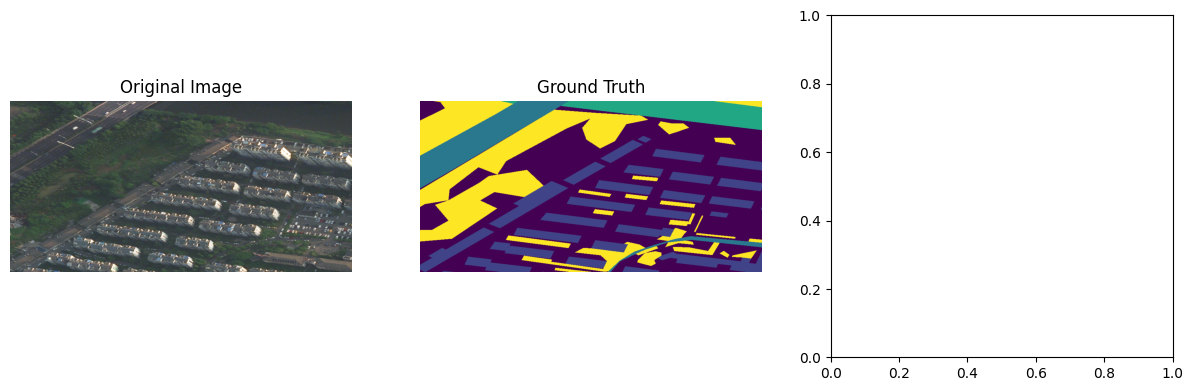

In [ ]:
import matplotlib.pyplot as plt

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

SAVE_MODEL_AS = f'best_model_STDC_{CHOOSE_TRANSFORM}.pth'

current_step = 0

best_loss = float('inf')
best_model = model.state_dict()

use_boundary_2 = True
use_boundary_4 = False
use_boundary_8 = True

model = model.to(DEVICE)
print(f"DEVICE is {DEVICE}")
if TYPE == 'Train':
  for epoch in range(NUM_EPOCHS):
    model.train()
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    epoch_loss = [0.0, 0]
    for (batch_i, batch) in enumerate(train_loader):
        optimizer.zero_grad()

        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)

        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images) # in model.train() mode batch size must be > 1 I think

        out, out16, out32, detail2, detail4, detail8 = outputs
        print(f"DEBUG: out {out.shape}")
        print(f"DEBUG: out16 {out16.shape}")
        print(f"DEBUG: out32 {out32.shape}")
        print(f"DEBUG: detail2 {detail2.shape}")
        print(f"DEBUG: detail4 {detail4.shape}")
        print(f"DEBUG: detail8 {detail8.shape}")


        # Compute boundary loss (optional)
        boundary_loss_func = DetailAggregateLoss().to(DEVICE)
        boundary_bce_loss = 0.
        boundary_dice_loss = 0.

        conv_to_boundary = nn.Conv2d(in_channels=out.size(1), out_channels=1, kernel_size=1).to(DEVICE)

        # Reduce channels for out, out16, and out32
        out_reduced = conv_to_boundary(out).to(DEVICE)
        out16_reduced = conv_to_boundary(out16)
        out32_reduced = conv_to_boundary(out32)

        # Now compute the boundary loss
        if use_boundary_2:
            boundary_bce_loss2, boundary_dice_loss2 = boundary_loss_func(out_reduced, bd_gts)
            boundary_bce_loss += boundary_bce_loss2
            boundary_dice_loss += boundary_dice_loss2

        if use_boundary_4:
            boundary_bce_loss4, boundary_dice_loss4 = boundary_loss_func(out16_reduced, bd_gts)
            boundary_bce_loss += boundary_bce_loss4
            boundary_dice_loss += boundary_dice_loss4

        if use_boundary_8:
            boundary_bce_loss8, boundary_dice_loss8 = boundary_loss_func(out32_reduced, bd_gts)
            boundary_bce_loss += boundary_bce_loss8
            boundary_dice_loss += boundary_dice_loss8



        # Upscale (bilinear interpolation - not learned)
        # h, w = masks.size(1), masks.size(2)
        # ph, pw = outputs[0].size(2), outputs[0].size(3)
        # if ph != h or pw != w:
        #     for i in range(len(outputs)):
        #         outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # print(f"DEBUG: outputs shapes below: ({len(outputs)} of them)")
        # for output in outputs:
        #     print(output.shape)
        # print(f"DEBUG: in particular, shape of outputs[-2] is {outputs[-2].shape}")

        ## Losses
        # Semantic Losses (l_0 and l_2)
        loss_s = sem_loss(out, masks) # output #1 and #2 are segmentation predictions


        # Complete Loss
        total_loss = loss_s + boundary_bce_loss + boundary_dice_loss

        ### Backprop
        if batch_i % LOG_FREQUENCY == 0:
            print(f'Loss at batch {batch_i}: {total_loss.item()}')
        total_loss.backward()

        optimizer.step()
        epoch_loss[0] += total_loss.item()
        epoch_loss[1] += images.size(0)

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(masks[0].cpu().numpy())
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(torch.argmax(out, dim=0).cpu().numpy())
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()

'''
    # Evaluate model on the evaluation set and save the parameters if is better than best model
    model.eval()
    total_loss = 0.0
    outputs = []
    with torch.no_grad():
      for (batch_i, batch) in enumerate(validation_loader):
        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.float().to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)

        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images)

        ## Upscale (bilinear interpolation - not learned)
        h, w = masks.size(1), masks.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        ## Losses
        # Semantic Losses (l_0 and l_2)
        loss_s = sem_loss(outputs[:-1], masks)

        # Boundary Loss (l_1)
        loss_b = bd_loss(outputs[-1], bd_gts)

        # Boundary AwareneSS (BAS) Loss (l_3)
        filler = torch.ones_like(masks) * -1
        bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
        loss_sb = sem_loss([outputs[-2]], bd_label)

        # Complete Loss
        loss = loss_s + loss_b + loss_sb
        ### <=== Forward, Upscale, Compute Losses
        total_loss += loss.item()

    print('Epoch {}, Loss {}'.format(epoch+1, total_loss))
    if total_loss < best_loss:
      best_loss = total_loss
      best_model = model.state_dict()
      #Save in Drive and local
      torch.save(best_model, SAVE_MODEL_AS)
      if SAVE_ON_DRIVE:
        !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
        print(f"model succesfully saved on drive. loss went down to {best_loss}")

    current_step += 1
    scheduler.step()
    print(f'[EPOCH {epoch+1}] Avg. Loss: {epoch_loss[0] / epoch_loss[1]}')

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(masks[0].cpu().numpy())
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()
    '''

# TEST

In [ ]:
!pip install torchmetrics ptflops

In [ ]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops

TYPE = 'Test'
TARGET = 'Urban'
#Load best_model
#!cp /content/drive/MyDrive/LoveDA/best_model_step2b.pth /content/best_model_step2b.pth

model = get_seg_model(cfg, imgnet_pretrained=False)
best_model = torch.load(f'/content/best_model_PIDNet_{CHOOSE_TRANSFORM}.pth', weights_only=True)
model.load_state_dict(best_model)
model = model.to(DEVICE)

accuracy, mIoU = True, True

#using type = train i have more images (0.8)
test_dataset = LoveDADataset(transforms=AUGMENTATIONS['None'], split=TARGET, type='Validation', useBoundaries=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

#### TEST LOOP
model.eval()
print('Validation on Target', TARGET)
print('Model: ', CHOOSE_TRANSFORM)
print('Test images transformed with ', 'RandomCrop')
# Latency
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):
        _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
    end_time = time.time()
latency = (end_time - start_time) / 100
print(f"Latency: {latency:.4f} seconds")

# FLOPs
macs, _ = ptflops.get_model_complexity_info(model,
  (3, RESIZE, RESIZE), as_strings=False,
  print_per_layer_stat=False, verbose=False)
flops = macs * 2  # MACs perform two FLOPs
print("FLOPs:", flops)

# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

if TYPE == 'Test':
  with torch.no_grad():
      total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
      total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
      meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
      for (batch) in tqdm(test_loader):
          ### Extract input
          images, masks, img_path, bd_gts = batch
          images = images.float().to(DEVICE)
          masks = masks.to(DEVICE)

          ### ===> Forward, Upscale, Compute Losses
          ## Forward
          outputs = model(images)

          ## Upscale (bilinear interpolation - not learned)
          h, w = masks.size(1), masks.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          # Output 1 is the prediction

          # Shape: NBATCHES x classes x h x w
          class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

          if accuracy:
          # Create a mask for valid targets (where target is not -1)
            valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
            # Apply the mask to ignore -1 targets when updating the accuracy metric
            meter.update(class_indices[valid_mask], masks[valid_mask])

          if mIoU:
            for predicted, target in zip(class_indices, masks):
              for i in range(NUM_CLASSES):
                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

  if accuracy:
    accuracy = meter.compute()
    print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

  if mIoU:
    intersection_over_union = total_intersection / total_union

    # Per class IoU
    for i, iou in enumerate(intersection_over_union):
        class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
        print(f'{class_name} IoU: {iou:.4f}')

    mIoU = torch.mean(intersection_over_union)
    print(f'\nmIoU on the target domain: {mIoU}')


In [ ]:
!cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
print(f"model succesfully saved on drive. loss went down to {best_loss}")